# Speech Emotion Recognition Model CNN/LSTM | Part 3

## Overview of the Notebook

This code is a notebook focused on **loading a pre-trained Speech Emotion Recognition (SER) model, performing feature extraction on an audio file, and making a prediction** based on the emotional content of the audio.

### Key Sections

1. **Library Imports**:
   - Essential libraries for audio processing (`librosa`, `pydub`), data handling (`numpy`, `pickle`), and deep learning (`tensorflow`) are imported.
   - `IPython.display` is used to play audio files directly in the notebook.


2. **Model and Preprocessing Artifacts Loading**:
   - Loads the pre-trained CNN/LSTM model structure and weights from JSON and HDF5 files.
   - Loads the `StandardScaler` and `OneHotEncoder` objects saved from previous preprocessing steps. These are used to standardize and encode features for consistent input into the model.


3. **Audio File Analysis**:
   - The code takes an input audio file, `happiness.wav`, and loads it with `librosa`.
   - Basic visualization is done using:
     - A **waveform plot** to display the time-domain representation.
     - A **spectrum plot** to analyze frequency components.
     - A **Mel spectrogram** to examine energy across different frequencies, providing more insights into tonal quality.


4. **Feature Extraction**:
   - Defines several helper functions to extract features from the audio:
     - `zcr()`: Calculates zero-crossing rate, capturing signal noisiness.
     - `rmse()`: Calculates root-mean-square energy, giving amplitude information.
     - `mfcc()`: Extracts Mel Frequency Cepstral Coefficients, essential for capturing human voice characteristics.
   - Combines these features in `extract_features()`, creating a comprehensive feature vector for model input.


5. **Prediction Function**:
   - **Feature Preparation**:
     - `get_predict_feat()`: Takes the file path, extracts and standardizes features, ensuring the feature vector matches the input shape expected by the model.
   - **Prediction**:
     - `prediction()`: Uses the pre-trained model to predict the emotional state in the input audio. It identifies the emotion with the highest confidence and displays each emotion label's confidence score, providing insights into the model's certainty.


6. **Results**:
   - The predicted emotion label and associated confidence scores are displayed, allowing a review of model performance for each emotion class.


### Key Points
- **Scalability**: Can be adapted for different audio files by adjusting `input_path`.
- **Interpretability**: Provides confidence scores for each class, which can be helpful for analysis.
- **Use Case**: This setup is suited for testing or deploying SER on new audio files, using pre-saved model weights and preprocessing artifacts.

This notebook efficiently serves as a standalone tool for real-time emotion detection in audio.

# Import Libraries

In [5]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import librosa

import numpy as np
import matplotlib.pyplot as plt

import pydub as pyd
import IPython.display as ipd

import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))

# Import Models

## Speech Emotion Recognition Model

In [6]:
json_file = open('results/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [7]:
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("results/best_model.weights.h5")

In [9]:
with open('results/scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)

with open('results/encoder.pickle', 'rb') as f:
    encoder = pickle.load(f)

/home/aegis/Research/Machine Learning in HEP/mlenv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/aegis/Research/Machine Learning in HEP/mlenv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 1. Audio file Analysis

In [10]:
# set input path to any audio file
input_path = "wan_angry.wav"

In [11]:
# Load audio data
audio_data, audio_sr = librosa.load(input_path)

# Audio
ipd.Audio(audio_data, rate=audio_sr)

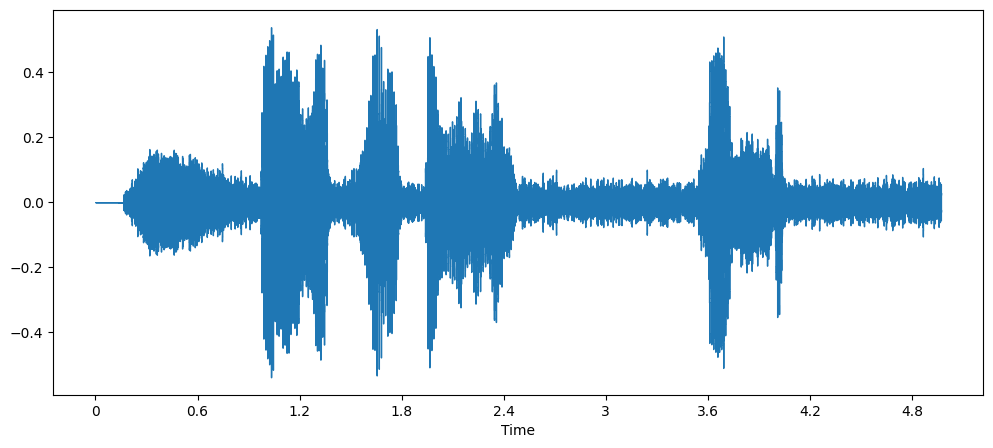

In [12]:
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=audio_data, sr=audio_sr);

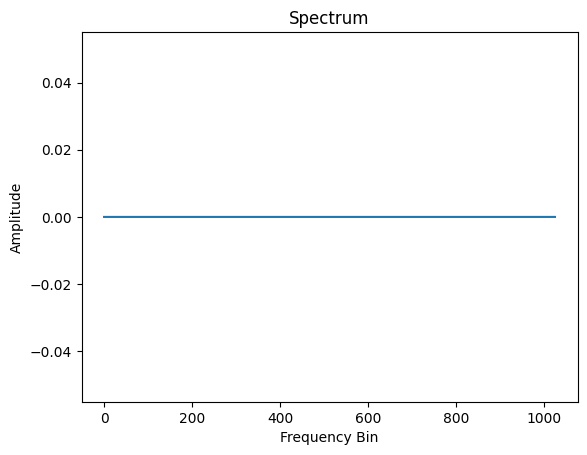

In [13]:
n_fft = 2048
D = np.abs(librosa.stft(audio_data[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');
plt.plot(D);

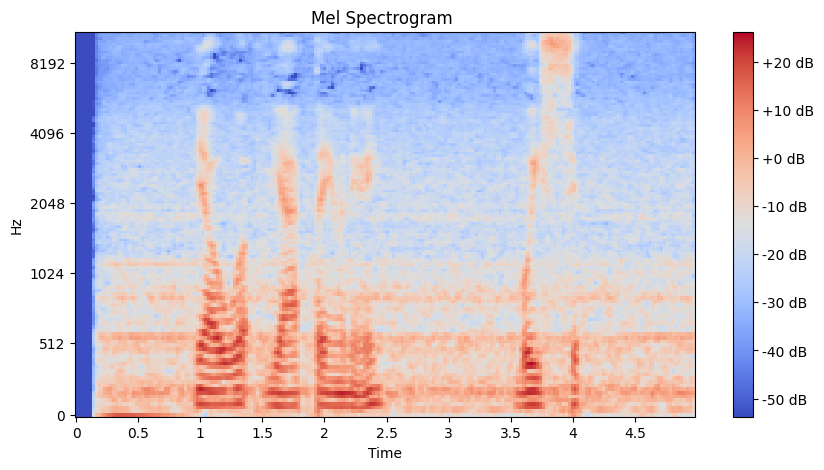

In [14]:
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=audio_sr, n_mels=128,fmax=8000)
log_spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=audio_sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.colorbar(format='%+2.0f dB');

# 2. Speech Emotion Recognition Module

In [15]:
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(mfcc_result.T) if not flatten else np.ravel(mfcc_result.T)

def extract_features(data,sr=22050,frame_length=2048,hop_length=512):
    result=np.array([])

    result=np.hstack((
      result,
      zcr(data,frame_length,hop_length),
      rmse(data,frame_length,hop_length),
      mfcc(data,sr,frame_length,hop_length)
    ))

    return result

In [16]:
def get_predict_feat(path, expected_shape=(1, 2376)):
    d, s_rate = librosa.load(path, duration=2.5, offset=0.6)
    res = extract_features(d)

    # Ensure res is reshaped or padded to match the expected shape
    if res.shape != expected_shape:
        flat_size = np.prod(expected_shape)
        if res.size < flat_size:
            # Pad if the size is smaller than expected
            pad_width = (0, flat_size - res.size)
            res = np.pad(res, pad_width=pad_width, mode='constant')
        else:
            # Resize if the size is larger than expected
            res = np.resize(res, expected_shape)

    i_result = scaler.transform(res.reshape(1, -1))
    final_result = np.expand_dims(i_result, axis=2)

    return final_result

In [17]:
def prediction(path1):
    res = get_predict_feat(path1)
    predictions = loaded_model.predict(res)

    # Get the label names or define them if available
    label_names = list(encoder.categories_[0])

    # Get the index of the label with the highest confidence score
    predicted_label_index = np.argmax(predictions)

    # List to store confidence scores
    confidence_scores = []

    # Display predicted emotion and confidence for each label
    print(f"\nPredicted Emotion: {label_names[predicted_label_index]}")
    for label_index, label_name in enumerate(label_names):
        confidence_score = predictions[0][label_index]
        confidence_score = 0 if confidence_score < 0.001 else confidence_score
        confidence_scores.append({'label': label_name, 'confidence': confidence_score})

    print("\n")

    sorted_confidence_scores = sorted(confidence_scores, key=lambda x: x['confidence'], reverse=True)

    return sorted_confidence_scores

In [18]:
prediction(input_path)

I0000 00:00:1744707132.490027   13766 service.cc:152] XLA service 0x75e2b40152c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744707132.490299   13766 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-04-15 16:52:12.634379: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step

I0000 00:00:1744707133.556712   13766 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Predicted Emotion: neutral




[{'label': 'neutral', 'confidence': 0.70870984},
 {'label': 'disgust', 'confidence': 0.24021313},
 {'label': 'sad', 'confidence': 0.050974213},
 {'label': 'angry', 'confidence': 0},
 {'label': 'fear', 'confidence': 0},
 {'label': 'happy', 'confidence': 0},
 {'label': 'surprise', 'confidence': 0}]

# Next Steps 

## 1. Build A CNN Model for Text Emotion Recognition

This notebook [Text Emotion Analysis using CNN](https://www.kaggle.com/code/rikinzala/text-emotion-analysis-using-cnn) will focus on creating NLP model that will analyse the emotions of text dataset. It is build upon the preprocessed and augmented text data to assess the model's performance on new data.

## 2. Wrapping Up

Since we are now with both Audio and Text ML models, we can create a python backend for Speech Emotion Recognition. Here is a github link for full implementation [SoulSyncopia](https://github.com/RikinZala25/Emotion-Music-Player). Consider checking all the branches.

## If you find the helpful consider giving an upvote, Thanks!